## Tentang Dataset
Dataset ini mencakup berbagai fitur yang berhubungan dengan cuaca dan mengkategorikan cuaca ke dalam empat jenis: `Rainy`, `Sunny`, `Cloudy`, dan `Snowy`.
<figure>
  <img src="https://scied.ucar.edu/sites/default/files/media/images/weather_0.jpg" alt="Weather image" width="600"/>
  <figcaption>Diagram illustrating key elements of weather processes, from NCAR..</figcaption>
</figure>


Dataset source: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification

In [1]:
pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


In [3]:
url = '/kaggle/input/weather-type-classification/weather_classification_data.csv'
df = pd.read_csv(url)
df.head(10)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
5,32.0,55,3.5,26.0,overcast,1010.03,2,Summer,5.0,inland,Cloudy
6,-2.0,97,8.0,86.0,overcast,990.87,1,Winter,4.0,inland,Snowy
7,3.0,85,6.0,96.0,partly cloudy,984.46,1,Winter,3.5,inland,Snowy
8,3.0,83,6.0,66.0,overcast,999.44,0,Winter,1.0,mountain,Snowy
9,28.0,74,8.5,107.0,clear,1012.13,8,Winter,7.5,coastal,Sunny


## 1. Exploratory Data Analysis

In [4]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
cat_cols

['Cloud Cover', 'Season', 'Location', 'Weather Type']

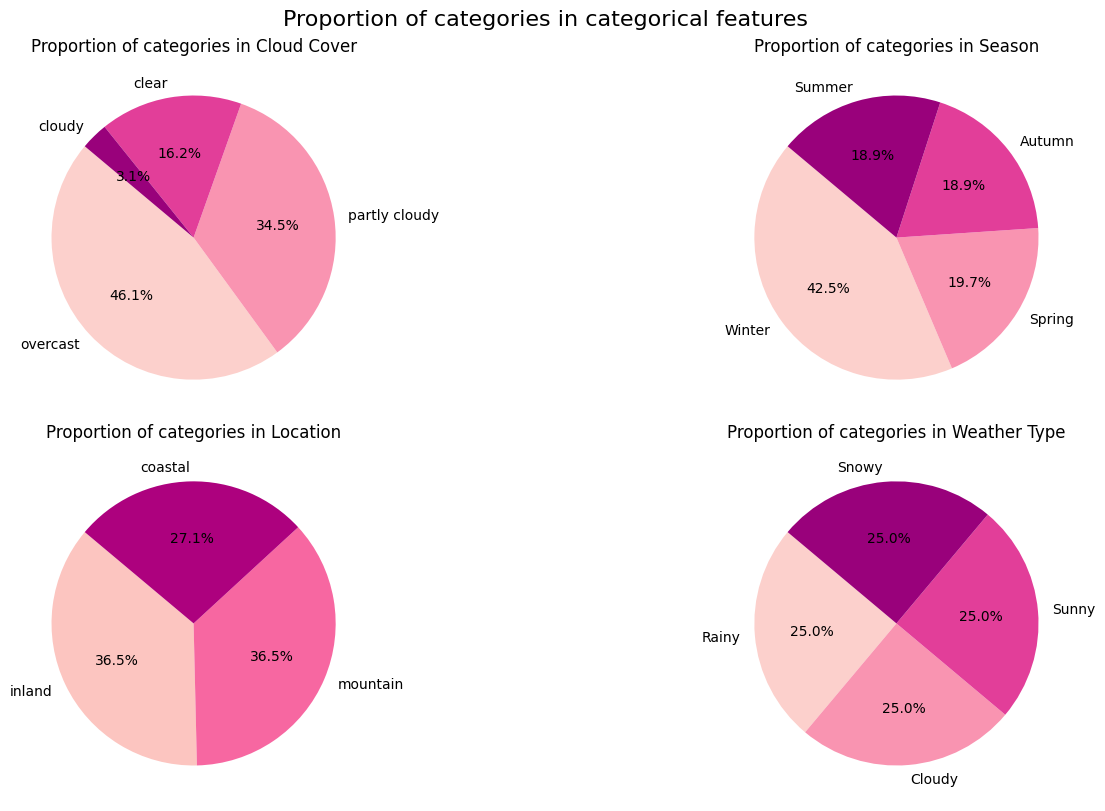

In [5]:
n = len(cat_cols)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), constrained_layout=True)

axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    counts = df[col].value_counts()

    colors = sns.color_palette('RdPu', n_colors=len(counts))

    # Plot
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(f'Proportion of categories in {col}')

# hide for unused subplots
for ax in axes[len(cat_cols):]:
    ax.axis('off')

fig.suptitle('Proportion of categories in categorical features', fontsize=16)
plt.show()

## 1.1 Distribution Analysis

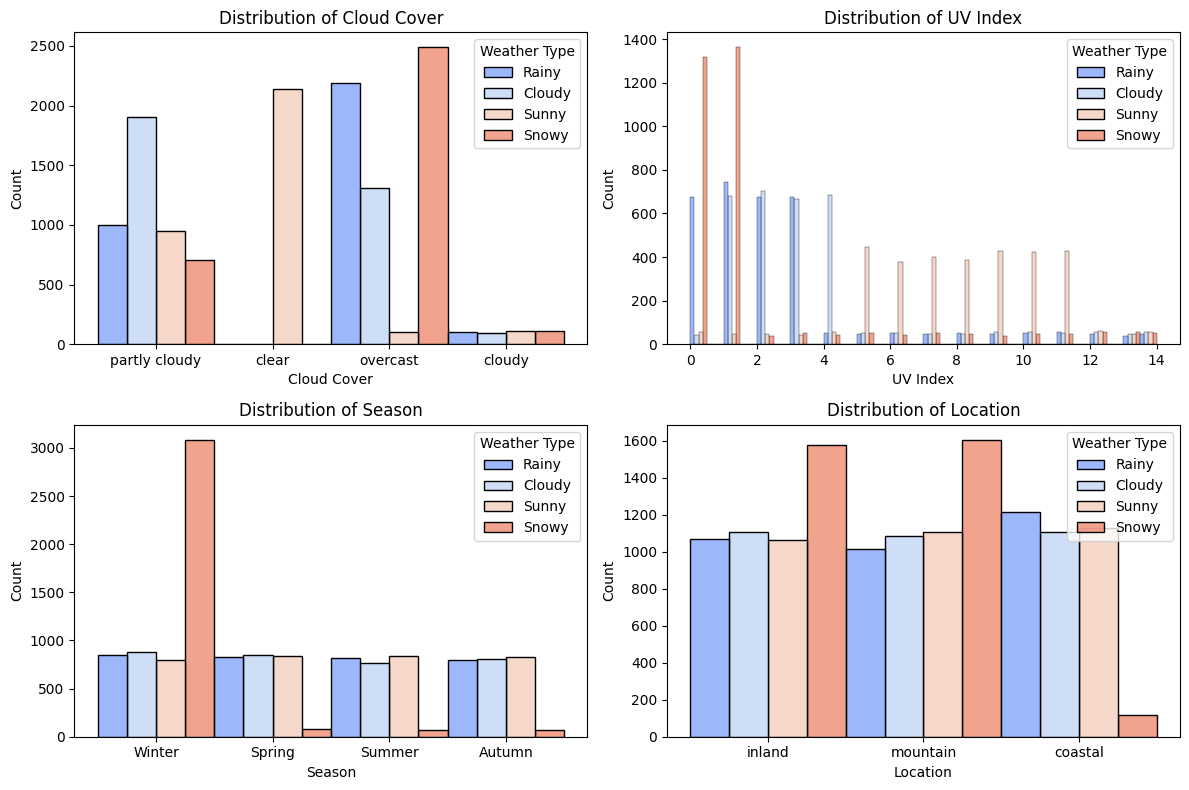

In [6]:
columns_to_plot = ['Cloud Cover', 'UV Index', 'Season', 'Location']

num_cols = len(columns_to_plot)
num_rows = (num_cols + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(x=df[col], hue=df["Weather Type"], multiple='dodge', palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# turn off axes for extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Konklusi**:

- **Cloud Cover**: Kondisi tutupan awan sangat mempengaruhi jenis cuaca, dengan cuaca cerah yang cenderung terjadi pada kondisi langit yang lebih cerah dan cuaca hujan atau berawan yang terjadi pada kondisi mendung.

- **UV Index**: UV Index menunjukkan seberapa kuat radiasi UV dari matahari. Ketika cuaca cerah, sinar matahari tidak terhalang, sehingga indeks UV cenderung lebih tinggi. Sebaliknya, ketika cuaca hujan, berawan, atau bersalju, awan dan partikel lainnya di atmosfer menghalangi sinar matahari, sehingga indeks UV menjadi lebih rendah.
Asumsi mengapa cuaca salju ada yang berdistribusi tinggi adalah sebagai berikut:
  - ***Ketinggian lokasi***: Jika cuaca bersalju terjadi di daerah dataran yang tinggi, indeks UV juga bisa lebih tinggi karena semakin lokasi tempat yang tinggi.
  - ***Refleksi dari salju***: Salju memiliki kemampuan untuk memantulkan sinar UV, sehingga meskipun cuaca mungkin berawan, sinar UV yang ada bisa dipantulkan dari permukaan salju dapat meningkatkan nilai indeks UV.

- **Season**: Musim mempengaruhi jenis cuaca yang dominan, dengan cuaca bersalju yang hampir eksklusif terjadi di musim dingin dan cuaca cerah lebih sering terjadi di musim panas.
- **Location**: Lokasi geografis juga memiliki pengaruh signifikan, di mana daerah pegunungan lebih sering mengalami cuaca bersalju, sedangkan daerah pantai lebih banyak mengalami cuaca cerah dan berawan.

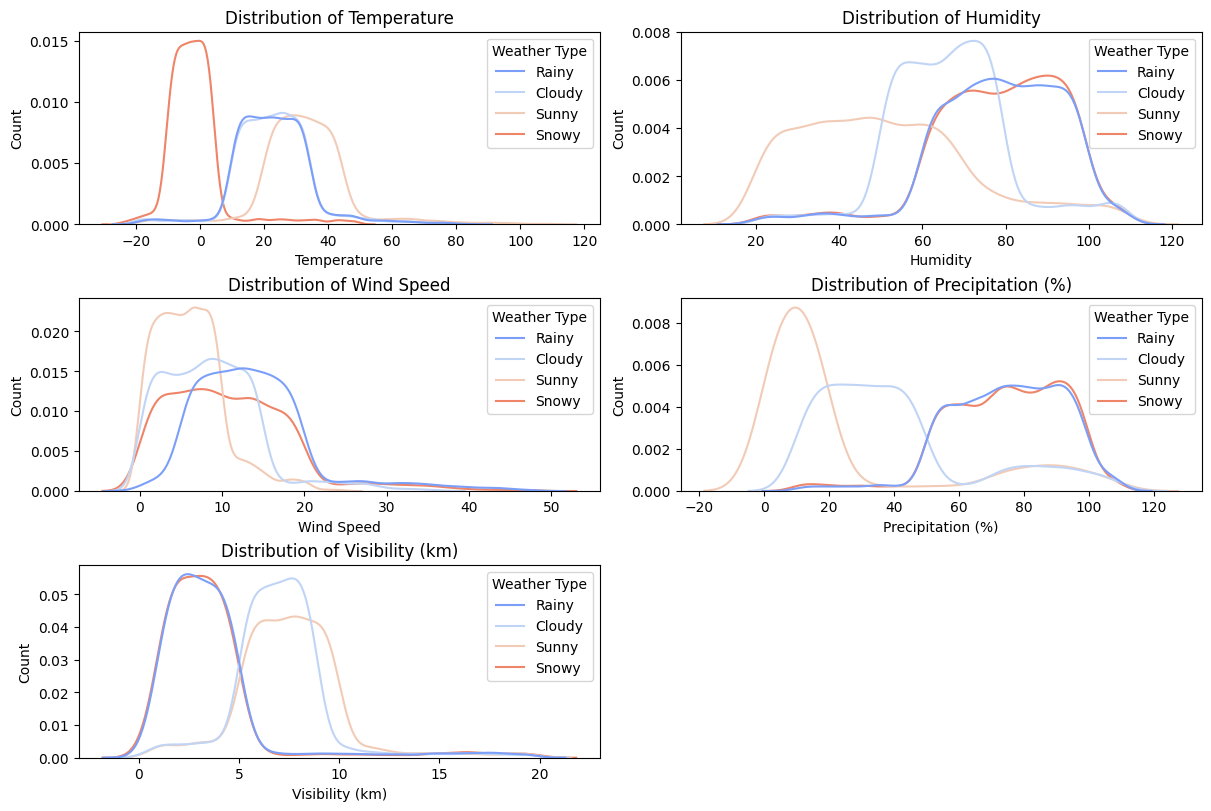

In [7]:
columns_to_plot = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Visibility (km)']

n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), constrained_layout=True)

axes = axes.flatten()

for ax, col in zip(axes, columns_to_plot):
    sns.kdeplot(x=df[col], hue=df['Weather Type'], palette='coolwarm', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])


plt.show()

**Konklusi**: <br>
- **Cuaca cerah (sunny)**: cenderung terjadi pada suhu yang lebih tinggi dengan kelembaban dan curah hujan yang lebih rendah serta visibilitas yang paling baik.

- **Cuaca hujan (rainy) dan bersalju (snowy)**: menunjukkan kelembaban tinggi, curah hujan yang signifikan, dan visibilitas yang lebih rendah, dengan suhu yang berkaitan dengan karakteristik masing-masing.

- **Cuaca berawan (cloudy)**: menunjukkan distribusi yang lebih bervariasi pada semua fitur, mencerminkan kondisi cuaca yang lebih beragam.

## 1.2 Feature Correlation

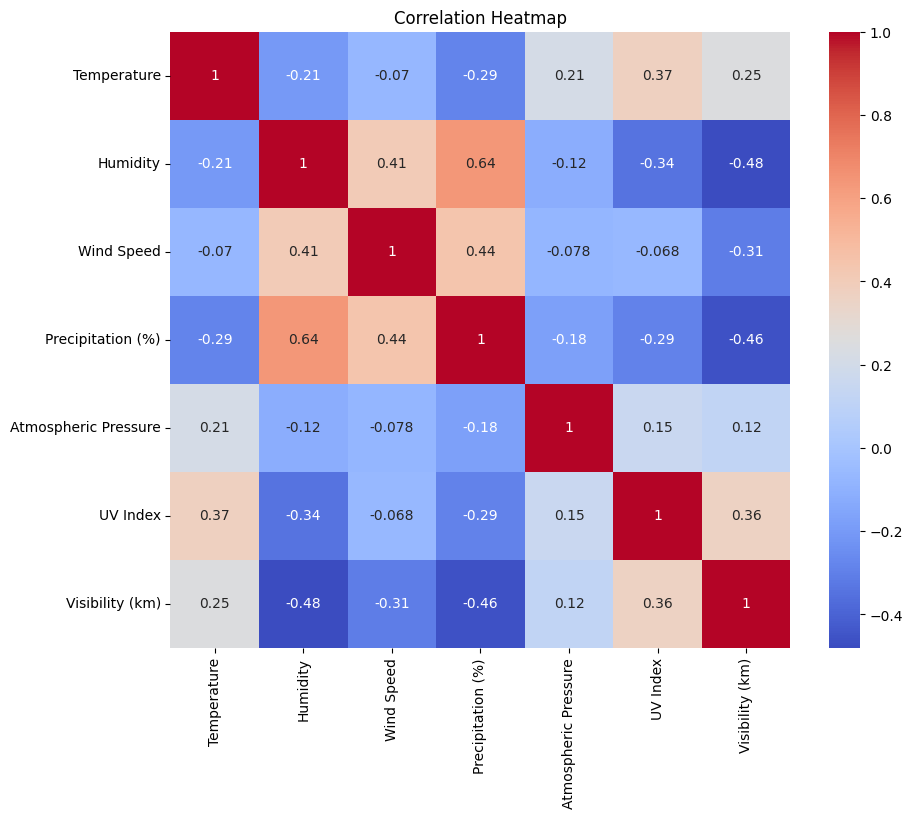

In [8]:
cols_to_use = df.describe().columns

plt.figure(figsize=(10,8))

correlation_matrix = df[cols_to_use].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 2. Data Cleansing

In [9]:
# Checking missing and duplicated values
print(f'There are {df.isna().sum().sum()} missing values in the dataset')
print(f'There are {df.duplicated().sum()} duplicate values in the dataset')

There are 0 missing values in the dataset
There are 0 duplicate values in the dataset


In [10]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')

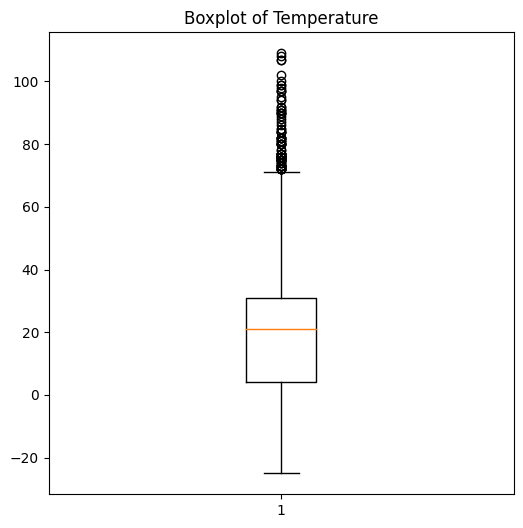

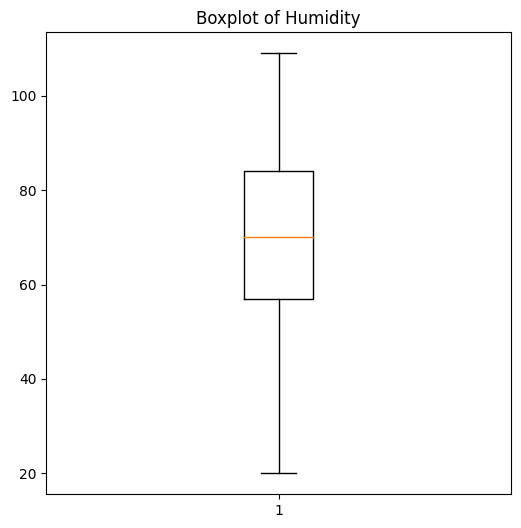

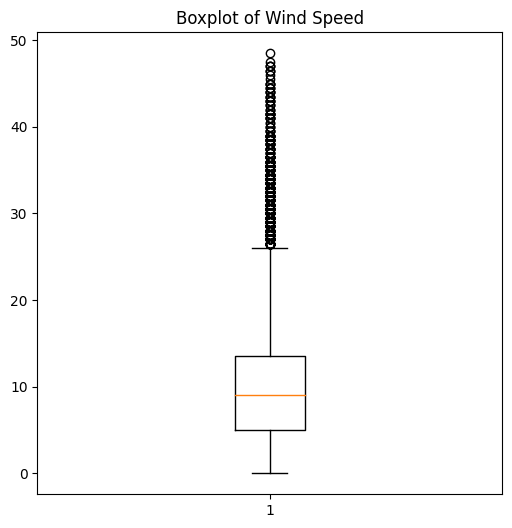

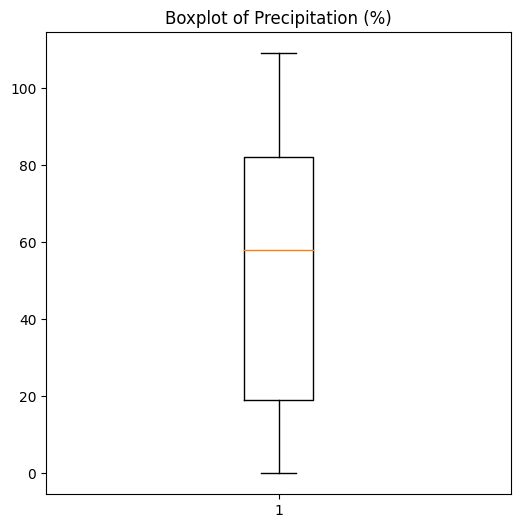

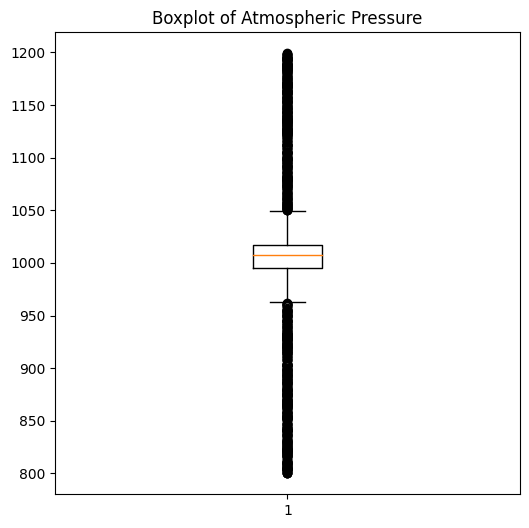

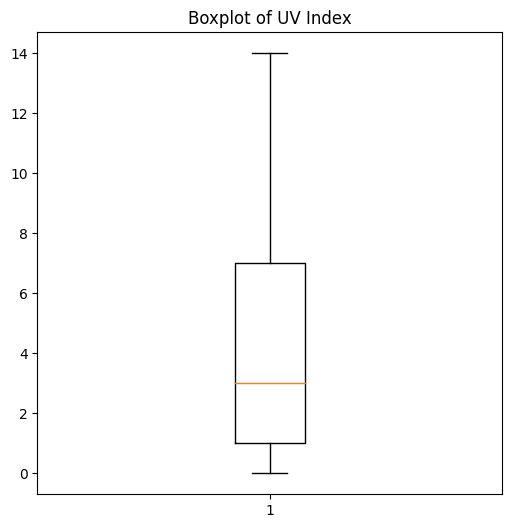

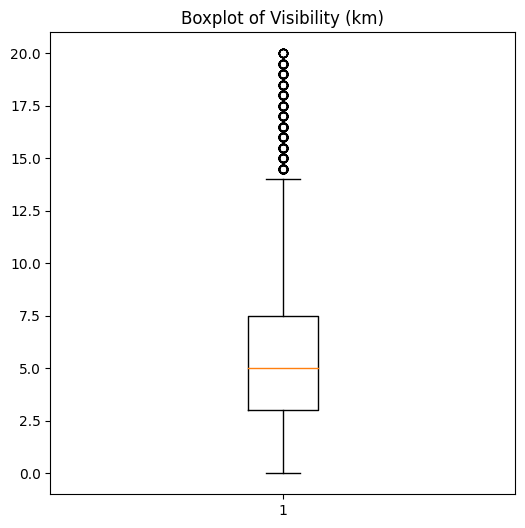

In [11]:
for col in numeric_columns:
    plt.figure(figsize=(6, 6))
    plt.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

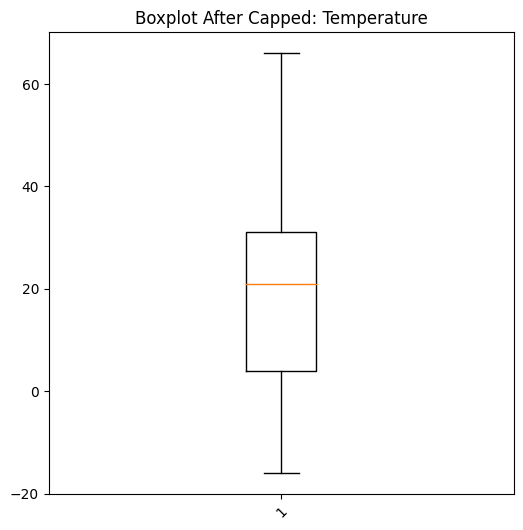

In [12]:
def cap_outliers(df, column, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df_capped = df.copy()

cap_variables = ['Temperature']

for column in cap_variables:
    df_capped = cap_outliers(df, column)

# Verify the changes by plotting the boxplot again
plt.figure(figsize=(6, 6))

for col in cap_variables:
  plt.boxplot(df_capped[col])
  plt.title(f'Boxplot After Capped: {col}')
  plt.xticks(rotation=45)
  plt.show()


## 3. Data Preprocessing

Split dataset menjadi train & test set

In [13]:
df_capped.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Weather Type'],
      dtype='object')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df_capped.drop('Weather Type', axis=1),
    df_capped['Weather Type'],
    test_size=0.3,
    random_state=0
)

X_train.shape, y_train.shape

((9240, 10), (9240,))

## 3.1 Categorical Features Encoding
Metode Encoding Categorical values yang digunakan: `Ordinal / Label Encoding`

In [15]:
# Categorical features
encoder = OrdinalEncoder(
    variables=['Cloud Cover', 'Season', 'Location'],
    encoding_method='arbitrary'
)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [16]:
# For target variables
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

## 3.2 Feature Scaling
Metode Feature Scaling yang digunakan: `Standard Scaling`

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 4. Data Modelling
Hyperparameter tuning menggunakan GridSearchCV

In [18]:
# Create the models
model_lr = LogisticRegression(random_state=0)
model_xgb = XGBClassifier(random_state=0)
model_rf = RandomForestClassifier(random_state=0)
model_bayes = GaussianNB()

# Define parameter grids
param_grid_lr = {
    'C': [0.1, 1, 10],          # Regularization strength
    'solver': ['liblinear', 'saga']  # Optimization algorithm
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],   # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2], # Step size
    'max_depth': [3, 6, 9]            # Maximum tree depth
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],   # Number of trees
    'max_depth': [None, 10, 20, 30]   # Maximum tree depth
}

# Setup GridSearchCV
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid_lr, cv=5, scoring='accuracy')
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')

# Train the models
grid_search_lr.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
model_bayes.fit(X_train, y_train)


GaussianNB()

In [19]:
# Get the best model and parameters
best_lr = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Naive Bayes has no hyperparameters to tune, so we just fit it and check accuracy
accuracy_bayes = accuracy_score(y_test, model_bayes.predict(X_test))

# Print the results
print("Logistic Regression:")
print("Best parameters:", best_params_lr)
print("Best accuracy score:", best_score_lr)

print("\nXGBoost:")
print("Best parameters:", best_params_xgb)
print("Best accuracy score:", best_score_xgb)

print("\nRandom Forest:")
print("Best parameters:", best_params_rf)
print("Best accuracy score:", best_score_rf)

print("\nGaussian Naive Bayes:")
print("Accuracy score:", accuracy_bayes)

# Find the best model based on accuracy
best_model_name = ""
best_model_score = 0

if best_score_lr > best_model_score:
    best_model_name = "Logistic Regression"
    best_model_score = best_score_lr

if best_score_xgb > best_model_score:
    best_model_name = "XGBoost"
    best_model_score = best_score_xgb

if best_score_rf > best_model_score:
    best_model_name = "Random Forest"
    best_model_score = best_score_rf

if accuracy_bayes > best_model_score:
    best_model_name = "Gaussian Naive Bayes"
    best_model_score = accuracy_bayes

print("\nBest model:", best_model_name)
print("Best model accuracy score:", best_model_score)

Logistic Regression:
Best parameters: {'C': 10, 'solver': 'saga'}
Best accuracy score: 0.8676406926406927

XGBoost:
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
Best accuracy score: 0.9120129870129869

Random Forest:
Best parameters: {'max_depth': None, 'n_estimators': 200}
Best accuracy score: 0.9128787878787878

Gaussian Naive Bayes:
Accuracy score: 0.8694444444444445

Best model: Random Forest
Best model accuracy score: 0.9128787878787878


## 5. Model Evaluation
Metrics evaluasi yang digunakan adalah `accuracy_score`

In [20]:
best_rf = grid_search_rf.best_estimator_

# make predictions
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy score: {accuracy}')

Model Accuracy score: 0.9202020202020202
